# Quora Question Pairs - TF-IDF and Doc2Vec (Similarity Based Models)

The objective of this analysis is to use different Natural Language Processing methods to predict if pairs of questions have the same meaning. The data is from Quora and hosted on Kaggle: https://www.kaggle.com/quora/question-pairs-dataset. The sections of this analysis include:
- Transforming the text
- Method 1: TfidfVectorizer
- Method 2: Doc2Vec

In [ ]:
# !pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from gensim import utils
# from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/questions.csv'
df = pd.read_csv(file_path)
# df = pd.read_csv(r"../questions.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# Use the full dataset on your personal computer.
# I'm using a fraction so that it doesn't time out when uploading.
df = df[0:400000]

In [ ]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df.is_duplicate.value_counts()

,count
is_duplicate,
0,252209
1,147791


In [ ]:
25109/len(df)

0.0627725

In [ ]:
# Take a look at some of the question pairs.
print("Not duplicate:")
print(df.question1[0])
print(df.question2[0])
print()
print("Not duplicate:")
print(df.question1[1])
print(df.question2[1])
print()
print("Is duplicate:")
print(df.question1[5])
print(df.question2[5])

Not duplicate:
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

Not duplicate:
What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

Is duplicate:
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


In [ ]:
# def review_to_wordlist(review, remove_stopwords=True):
#     # Clean the text, with the option to remove stopwords.

#     # Convert words to lower case and split them
#     if len(review) == 0 or review == None or review == 'nan':
#       review = ''
#     words = review.lower().split()

#     # Optionally remove stop words (true by default)
#     if remove_stopwords:
#         stops = set(stopwords.words("english"))
#         words = [w for w in words if not w in stops]

#     review_text = " ".join(words)

#     # Clean the text
#     review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
#     review_text = re.sub(r"\'s", " 's ", review_text)
#     review_text = re.sub(r"\'ve", " 've ", review_text)
#     review_text = re.sub(r"n\'t", " 't ", review_text)
#     review_text = re.sub(r"\'re", " 're ", review_text)
#     review_text = re.sub(r"\'d", " 'd ", review_text)
#     review_text = re.sub(r"\'ll", " 'll ", review_text)
#     review_text = re.sub(r",", " ", review_text)
#     review_text = re.sub(r"\.", " ", review_text)
#     review_text = re.sub(r"!", " ", review_text)
#     review_text = re.sub(r"\(", " ( ", review_text)
#     review_text = re.sub(r"\)", " ) ", review_text)
#     review_text = re.sub(r"\?", " ", review_text)
#     review_text = re.sub(r"\s{2,}", " ", review_text)

#     words = review_text.split()

#     # Shorten words to their stems
#     stemmer = SnowballStemmer('english')
#     stemmed_words = [stemmer.stem(word) for word in words]

#     review_text = " ".join(stemmed_words)

#     # Return a list of words
#     return(review_text)

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pandas as pd

def review_to_wordlist(review, remove_stopwords=True):
    # Check for invalid or empty reviews (handles NaN and None)
    if not review or pd.isna(review) or review == 'nan':
        return ''  # Return an empty string if review is invalid or empty

    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]

    # Clean the text using regular expressions
    review_text = " ".join(words)
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)  # Remove unwanted characters
    review_text = re.sub(r"\'s", " 's ", review_text)  # Handle possessives
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r"[.,!?()]", " ", review_text)  # Remove punctuation (simplified)
    review_text = re.sub(r"\s{2,}", " ", review_text)  # Replace multiple spaces with a single space

    # Tokenize the cleaned text
    words = review_text.split()

    # Shorten words to their stems
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the stemmed words back into a string
    review_text = " ".join(stemmed_words)

    return review_text


In [ ]:
def process_questions(question_list, questions, question_list_name):
# function to transform questions and display progress
    for question in questions:
        question_list.append(review_to_wordlist(question))
        if len(question_list) % 10000 == 0:
            progress = len(question_list)/len(df) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [ ]:
# !pip install nltk
# import nltk
# nltk.download('stopwords')

In [ ]:
questions1 = []
process_questions(questions1, df.question1, "questions1")
print()
questions2 = []
process_questions(questions2, df.question2, "questions2")

questions1 is 2.5% complete.
questions1 is 5.0% complete.
questions1 is 7.5% complete.
questions1 is 10.0% complete.
questions1 is 12.5% complete.
questions1 is 15.0% complete.
questions1 is 17.5% complete.
questions1 is 20.0% complete.
questions1 is 22.5% complete.
questions1 is 25.0% complete.
questions1 is 27.5% complete.
questions1 is 30.0% complete.
questions1 is 32.5% complete.
questions1 is 35.0% complete.
questions1 is 37.5% complete.
questions1 is 40.0% complete.
questions1 is 42.5% complete.
questions1 is 45.0% complete.
questions1 is 47.5% complete.
questions1 is 50.0% complete.
questions1 is 52.5% complete.
questions1 is 55.0% complete.
questions1 is 57.5% complete.
questions1 is 60.0% complete.
questions1 is 62.5% complete.
questions1 is 65.0% complete.
questions1 is 67.5% complete.
questions1 is 70.0% complete.
questions1 is 72.5% complete.
questions1 is 75.0% complete.
questions1 is 77.5% complete.
questions1 is 80.0% complete.
questions1 is 82.5% complete.
questions1 is

In [ ]:
# Take a look at some of the processed questions.
for i in range(5):
    print(questions1[i])
    print(questions2[i])
    print()

step step guid invest share market india
step step guid invest share market

stori kohinoor koh i noor diamond
would happen indian govern stole kohinoor koh i noor diamond back

increas speed internet connect use vpn
internet speed increas hack dns

mental lone solv it
find remaind math 23 24 math divid 24 23

one dissolv water quik sugar salt methan carbon di oxid
fish would surviv salt water



In [ ]:
# Stores the indices of unusable questions
invalid_questions = []
for i in range(len(questions1)):
    # questions need to contain a vowel (which should be part of a full word) to be valid
    if not re.search('[aeiouyAEIOUY]', questions1[i]) or not re.search('[aeiouyAEIOUY]', questions2[i]):
    # Need to subtract 'len(invalid_questions)' to adjust for the changing index values as questions are removed.
        invalid_questions.append(i-len(invalid_questions))
print(len(invalid_questions))

348


In [ ]:
# list of invalid questions
invalid_questions

[812,
 1509,
 3303,
 3397,
 3658,
 3757,
 6870,
 7361,
 7812,
 9737,
 10098,
 10573,
 10602,
 11427,
 12799,
 13001,
 13781,
 15223,
 15478,
 17469,
 17495,
 18122,
 18521,
 19854,
 20051,
 20390,
 20494,
 20770,
 22213,
 23859,
 26770,
 28241,
 28949,
 31212,
 31725,
 31791,
 32671,
 32839,
 33188,
 33775,
 34722,
 35607,
 36274,
 36731,
 37155,
 38442,
 40595,
 43497,
 44957,
 47015,
 51934,
 52839,
 53701,
 53707,
 53912,
 54070,
 55462,
 55768,
 57688,
 60135,
 65317,
 67887,
 67900,
 71325,
 75836,
 76072,
 78528,
 81505,
 82677,
 88188,
 88360,
 89705,
 90435,
 91531,
 93031,
 96666,
 99294,
 99882,
 103978,
 104038,
 104899,
 105290,
 105714,
 106280,
 106698,
 107443,
 108189,
 108907,
 108937,
 109071,
 109237,
 113530,
 115271,
 121565,
 122540,
 124744,
 124969,
 127210,
 127299,
 128200,
 129787,
 130254,
 130670,
 133045,
 134318,
 135135,
 136315,
 136964,
 138537,
 138849,
 138898,
 139224,
 141624,
 143804,
 144250,
 144796,
 146830,
 147187,
 148255,
 150125,
 150563,


In [ ]:
# Remove the invalid questions
for index in invalid_questions:
    df = df[df.id != index]
    questions1.pop(index)
    questions2.pop(index)

# These questions are also unusable, but were not detected initially.
# They were found when the function 'cosine_sim' stopped due to an error.
unexpected_invalid_questions = [36460]#,42273,65937,304867,306828,353918]
for index in unexpected_invalid_questions:
    df = df[df.id != index]
    questions1.pop(index)
    questions2.pop(index)

In [ ]:
# Use TfidfVectorizer() to transform the questions into vectors,
# then compute their cosine similarity.
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [ ]:
print(len(questions1),len(questions2))

399651 399651


In [ ]:
# Tfidf_scores = []
# for i in range(len(questions1)):
#     score = cosine_sim(questions1[i], questions2[i])
#     Tfidf_scores.append(score)
#     if i % 10000 == 0:
#         progress = i/len(questions1) * 100
#         print("Similarity Scores is {}% complete.".format(round(progress,2)))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Create vectorizer with stop_words=None to prevent stop word removal
vectorizer = TfidfVectorizer(stop_words=None)

def cosine_sim(text1, text2):
    # Check if both texts are non-empty
    if not text1.strip() or not text2.strip():
        return 0  # Return zero similarity if either text is empty

    # Transform the texts to TF-IDF vectors and compute cosine similarity
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0, 1]

# Handle empty or NaN questions by replacing them with a default value ("empty")
questions1 = [q if q is not None and not pd.isna(q) and q.strip() else "empty" for q in questions1]
questions2 = [q if q is not None and not pd.isna(q) and q.strip() else "empty" for q in questions2]

Tfidf_scores = []

for i in range(len(questions1)):
    try:
        score = cosine_sim(questions1[i], questions2[i])
        Tfidf_scores.append(score)
    except ValueError as e:
        print(f"Error at index {i}: {e}")
        Tfidf_scores.append(0)  # Or some default value for the error case

    if i % 10000 == 0:
        progress = i / len(questions1) * 100
        print(f"Similarity Scores is {round(progress, 2)}% complete.")


Similarity Scores is 0.0% complete.
Similarity Scores is 2.5% complete.
Similarity Scores is 5.0% complete.
Similarity Scores is 7.51% complete.
Error at index 36459: empty vocabulary; perhaps the documents only contain stop words
Similarity Scores is 10.01% complete.
Error at index 42272: empty vocabulary; perhaps the documents only contain stop words
Similarity Scores is 12.51% complete.
Similarity Scores is 15.01% complete.
Error at index 65937: empty vocabulary; perhaps the documents only contain stop words
Similarity Scores is 17.52% complete.
Similarity Scores is 20.02% complete.
Similarity Scores is 22.52% complete.
Similarity Scores is 25.02% complete.
Similarity Scores is 27.52% complete.
Similarity Scores is 30.03% complete.
Similarity Scores is 32.53% complete.
Similarity Scores is 35.03% complete.
Similarity Scores is 37.53% complete.
Similarity Scores is 40.03% complete.
Similarity Scores is 42.54% complete.
Similarity Scores is 45.04% complete.
Similarity Scores is 47.54%

In [ ]:
print(len(Tfidf_scores))

399651


In [ ]:
# Check all the indices which are 0 (meaning, all the documents which contain stop words only)
zero_Tfidf_scores = 0
for score in Tfidf_scores:
    if score == 0:
        zero_Tfidf_scores += 1
print(zero_Tfidf_scores)

32480


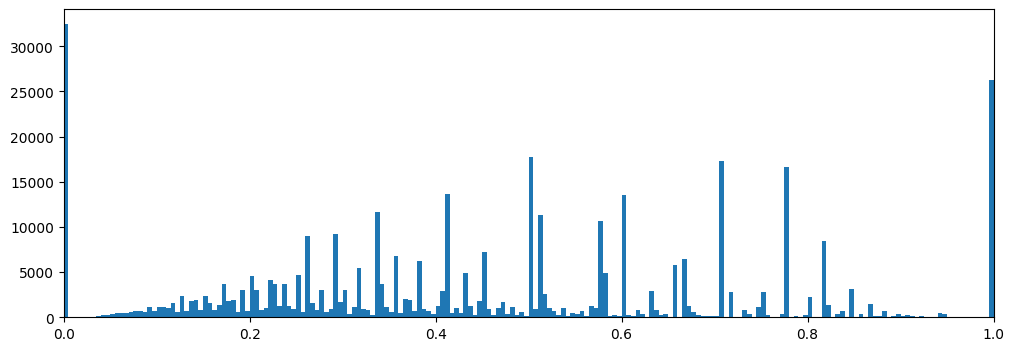

In [ ]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(Tfidf_scores, bins = 200)
plt.xlim(0,1)
plt.show()

In [ ]:
# Function to report the quality of the model
def performance_report(value, score_list):
    # the value (0-1) is the cosine similarity score to determine if a pair of questions
    # have the same meaning or not.
    scores = []
    for score in score_list:
        if score >= value:
            scores.append(1)
        else:
            scores.append(0)

    accuracy = accuracy_score(df.is_duplicate, scores) * 100
    print("Accuracy score is {}%.".format(round(accuracy),1))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(df.is_duplicate, scores))
    print()
    print("Classification Report:")
    print(classification_report(df.is_duplicate, scores))

In [ ]:
performance_report(0.52, Tfidf_scores)

Accuracy score is 64%.

Confusion Matrix:
[[180324  71670]
 [ 70334  77323]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72    251994
           1       0.52      0.52      0.52    147657

    accuracy                           0.64    399651
   macro avg       0.62      0.62      0.62    399651
weighted avg       0.65      0.64      0.65    399651



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Save the TfidfVectorizer model
vectorizer_filename = 'tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)
print(f"Model saved as '{vectorizer_filename}'.")

# Load the TfidfVectorizer model
loaded_vectorizer = joblib.load(vectorizer_filename)
print(f"Model loaded from '{vectorizer_filename}'.")

# Function to compute cosine similarity
def cosine_sim(text1, text2, vectorizer):
    tfidf = vectorizer.transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0, 1]

# Example questions
q1 = "How do I train a machine learning model?"
q2 = "What is the process of training a machine learning model?"


# Compute similarity
similarity_score = cosine_sim(q1, q2, loaded_vectorizer)
print(f"Cosine Similarity between q1 and q2: {similarity_score:.4f}")


Model saved as 'tfidf_vectorizer.pkl'.
Model loaded from 'tfidf_vectorizer.pkl'.
Cosine Similarity between q1 and q2: 0.0000


<!-- Using a threshold of 0.51 for the cosine similarity maximizes both the f1-score and accuracy. It's good to see that we are scoring better than the baseline value of 63.1% accuracy. -->


## Method 2: Doc2Vec

In [ ]:
# Reset index to match the index values of questions1 and questions2
df = df.reset_index()

In [ ]:
# # Contains the processed questions for Doc2Vec
# questions_labeled = []

# for i in range(len(questions1)):
#     # Question strings need to be separated into words
#     # Each question needs a unique label
#     questions_labeled.append(LabeledSentence(questions1[i].split(), df[df.index == i].qid1))
#     questions_labeled.append(LabeledSentence(questions2[i].split(), df[df.index == i].qid2))
#     if i % 10000 == 0:
#         progress = i/len(questions1) * 100
#         print("{}% complete".format(round(progress, 2)))

In [ ]:
# Contains the processed questions for Doc2Vec
questions_labeled = []

for i in range(len(questions1)):
    # Question strings need to be separated into words
    # Each question needs a unique label
    questions_labeled.append(TaggedDocument(questions1[i].split(), df[df.index == i].qid1))
    questions_labeled.append(TaggedDocument(questions2[i].split(), df[df.index == i].qid2))
    if i % 10000 == 0:
        progress = i/len(questions1) * 100
        print("{}% complete".format(round(progress, 2)))

0.0% complete
2.5% complete
5.0% complete
7.51% complete
10.01% complete
12.51% complete
15.01% complete
17.52% complete
20.02% complete
22.52% complete
25.02% complete
27.52% complete
30.03% complete
32.53% complete
35.03% complete
37.53% complete
40.03% complete
42.54% complete
45.04% complete
47.54% complete
50.04% complete
52.55% complete
55.05% complete
57.55% complete
60.05% complete
62.55% complete
65.06% complete
67.56% complete
70.06% complete
72.56% complete
75.07% complete
77.57% complete
80.07% complete
82.57% complete
85.07% complete
87.58% complete
90.08% complete
92.58% complete
95.08% complete
97.59% complete


In [ ]:
# Split questions for computing similarity and determining the lengths of the questions.
questions1_split = []
for question in questions1:
    questions1_split.append(question.split())

questions2_split = []
for question in questions2:
    questions2_split.append(question.split())

In [ ]:
# Determine the length of questions to select more optimal parameters.
lengths = []
for i in range(len(questions1_split)):
    lengths.append(len(questions1_split[i]))
    lengths.append(len(questions2_split[i]))
lengths = pd.DataFrame(lengths, columns=["count"])

In [ ]:
lengths['count'].describe()

,count
count,799302.000000
mean,5.818323
std,3.366819
min,1.000000
25%,4.000000
50%,5.000000
75%,7.000000
max,106.000000


In [ ]:
# 99% of the questions include 18 or fewer words.
np.percentile(lengths['count'], 99)

17.0

In [ ]:
# Build the model
model = Doc2Vec(dm = 1, min_count=1, window=10, vector_size=150, sample=1e-4, negative=10)
model.build_vocab(questions_labeled)

In [ ]:
# Train the model
# Train the model for 5 epochs
for epoch in range(5):
    model.train(questions_labeled, total_examples=model.corpus_count, epochs = model.epochs)
    print(f"Epoch #{epoch + 1} is complete.")


Epoch #1 is complete.


Epoch #2 is complete.


Epoch #3 is complete.


Epoch #4 is complete.
Epoch #5 is complete.


In [ ]:
# Save the model to disk
model_filename = 'doc2vec_model'
model.save(model_filename)
print(f'Model saved as {model_filename}')

Model saved as doc2vec_model


In [ ]:
# from gensim.models import Doc2Vec
# from scipy.spatial.distance import cosine

# # Load the saved model
# model_filename = 'doc2vec_model'
# loaded_model = Doc2Vec.load(model_filename)
# print(f'Model loaded from {model_filename}')

# # Example questions
# q1 = "How do I train a machine learning model?"
# q2 = "What is the process of training a machine learning model?"

# # Convert the questions to vectors using the loaded model
# q1_vector = loaded_model.infer_vector(q1.split())
# q2_vector = loaded_model.infer_vector(q2.split())

# # Compute cosine similarity between the two vectors
# similarity = 1 - cosine(q1_vector, q2_vector)

# # Print the similarity score
# print(f"Cosine Similarity between q1 and q2: {similarity:.4f}")


Model loaded from doc2vec_model
Cosine Similarity between q1 and q2: 0.3433


In [ ]:
# print(model.dv.index_to_key[:10])  # Check the first 10 words in the vocabulary
# print(model.dv.index_to_key[:20])  # Displays the top 20 document IDs
print(model.wv.index_to_key[:100])

['best', 'get', "'s", 'india', 'like', 'use', 'peopl', 'good', 'way', 'differ', 'would', 'make', 'one', 'quora', 'learn', 'time', 'life', 'work', 'year', 'know', 'money', 'what', 'thing', 'question', 'think', 'mean', 'indian', 'go', 'start', 'new', 'much', 'someon', 'engin', 'book', 'mani', 'becom', 'day', 'find', 'want', 'job', 'trump', 'movi', 'happen', 'ever', 'without', 'world', 'feel', 'onlin', 'first', 'better', 'person', 'girl', 'take', 'note', 'love', 'compani', 'it', 'english', 'whi', 'need', 'univers', '2', 'us', 'account', 'possibl', 'improv', 'buy', 'phone', 'program', 'could', '2016', 'prepar', '1', 'number', 'countri', 'ask', 'compar', 'live', 'chang', '500', 'languag', '1000', 'student', 'friend', 'studi', 'weight', 'realli', 'do', 'app', 'googl', 'donald', 'lose', 'answer', 'stop', 'busi', '3', 'long', 'old', 'websit', 'develop']


In [ ]:
# Check a few terms to ensure the model was trained properly.
model.wv.most_similar('appli')

[('graduat', 0.7753690481185913),
 ('get', 0.7741609215736389),
 ('student', 0.7717996835708618),
 ('offer', 0.7622742056846619),
 ('degre', 0.7601736783981323),
 ('visa', 0.7578496336936951),
 ('studi', 0.7528149485588074),
 ('join', 0.7363245487213135),
 ('work', 0.7351437211036682),
 ('job', 0.7349839210510254)]

In [ ]:
model.wv.most_similar('peopl')

[('person', 0.9011774659156799),
 ('other', 0.8851295113563538),
 ('them', 0.8720452785491943),
 ('someon', 0.8701930642127991),
 ('even', 0.8651589751243591),
 ('like', 0.8582855463027954),
 ('think', 0.8556405901908875),
 ('realli', 0.8540045619010925),
 ('whi', 0.8493725657463074),
 ('one', 0.8478968143463135)]

In [ ]:
model.wv.most_similar('book')

[('read', 0.813001275062561),
 ('learn', 0.7585887908935547),
 ('write', 0.753396213054657),
 ('good', 0.7332706451416016),
 ('onlin', 0.7270148992538452),
 ('one', 0.722239077091217),
 ('best', 0.7198824882507324),
 ('program', 0.7161550521850586),
 ('find', 0.7128171324729919),
 ('physic', 0.7055271863937378)]

In [ ]:
# doc2vec_scores = []
# for i in range(len(questions1_split)):
#     # n_similarity computes the cosine similarity in Doc2Vec
#     score = model.n_similarity(questions1_split[i],questions2_split[i])
#     doc2vec_scores.append(score)
#     if i % 10000 == 0:
#         progress = i/len(questions1_split) * 100
#         print("{}% complete.".format(round(progress,2)))

In [ ]:
# from scipy.spatial.distance import cosine

doc2vec_scores = []
for i in range(len(questions1_split)):
    # Use infer_vector() to compute the vector for each split sentence (list of words)
    vector1 = model.infer_vector(questions1_split[i])  # For the first question
    vector2 = model.infer_vector(questions2_split[i])  # For the second question

    # Compute cosine similarity between the two vectors
    score = 1 - cosine(vector1, vector2)  # Cosine similarity = 1 - cosine distance
    doc2vec_scores.append(score)

    if i % 10000 == 0:
        progress = i / len(questions1_split) * 100
        print("{}% complete.".format(round(progress, 2)))


0.0% complete.
2.5% complete.
5.0% complete.
7.51% complete.
10.01% complete.
12.51% complete.
15.01% complete.
17.52% complete.
20.02% complete.
22.52% complete.
25.02% complete.
27.52% complete.
30.03% complete.
32.53% complete.
35.03% complete.
37.53% complete.
40.03% complete.
42.54% complete.
45.04% complete.
47.54% complete.
50.04% complete.
52.55% complete.
55.05% complete.
57.55% complete.
60.05% complete.
62.55% complete.
65.06% complete.
67.56% complete.
70.06% complete.
72.56% complete.
75.07% complete.
77.57% complete.
80.07% complete.
82.57% complete.
85.07% complete.
87.58% complete.
90.08% complete.
92.58% complete.
95.08% complete.
97.59% complete.


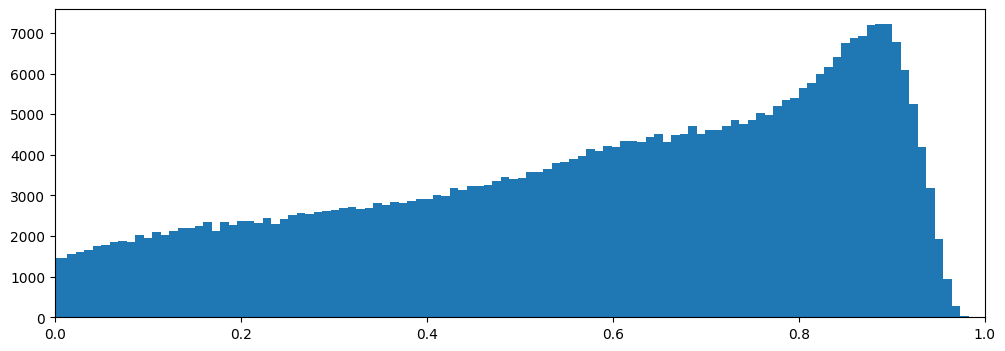

In [ ]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(doc2vec_scores, bins = 200)
plt.xlim(0,1)
plt.show()

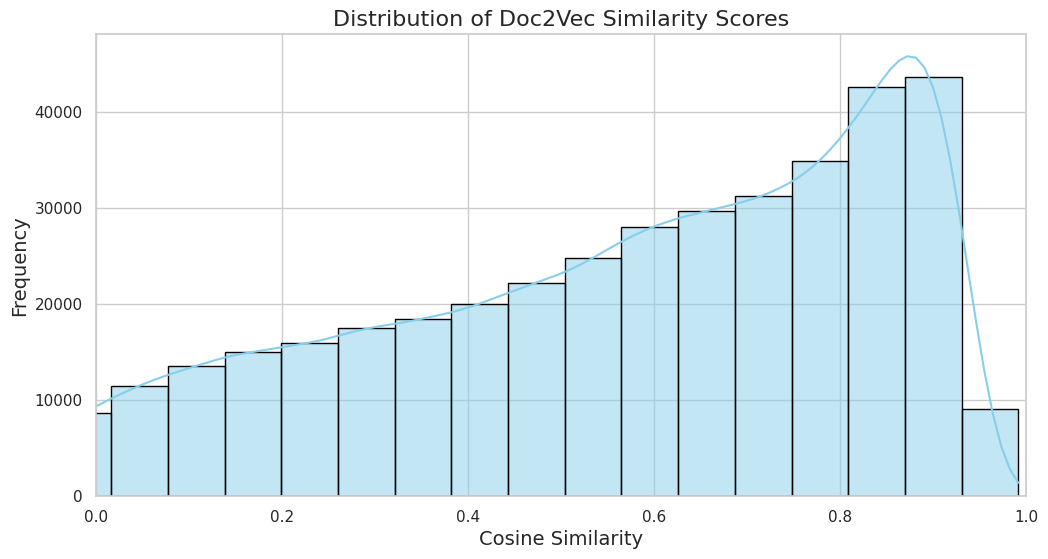

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12,6))

# Plot with Seaborn's histplot
sns.histplot(doc2vec_scores, bins=30, kde=True, color="skyblue", edgecolor="black")

# Set the title and labels
plt.title("Distribution of Doc2Vec Similarity Scores", fontsize=16)
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Set xlim for better clarity (0 to 1, as similarity scores are between 0 and 1)
plt.xlim(0, 1)

# Display the plot
plt.show()


It's interesting to see how Doc2Vec computes the pairs of questions to be more similar than TfidfVectorizer.

In [ ]:
performance_report(0.92, doc2vec_scores)

Accuracy score is 64%.

Confusion Matrix:
[[245452   6542]
 [139227   8430]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77    251994
           1       0.56      0.06      0.10    147657

    accuracy                           0.64    399651
   macro avg       0.60      0.52      0.44    399651
weighted avg       0.61      0.64      0.52    399651



TF_IDF OUTPUT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/questions.csv'

Mounted at /content/drive


In [ ]:

import joblib
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os

# Directory to load the vectorizer from
vectorizer_dir = '/content/drive/My Drive/Colab_Notebooks/Models/similarity_models/'

# Define the vectorizer filename
vectorizer_filename = os.path.join(vectorizer_dir, 'tfidf_vectorizer.pkl')

# Load the saved TfidfVectorizer
loaded_vectorizer = joblib.load(vectorizer_filename)
print(f"Vectorizer loaded from '{vectorizer_filename}'.")

# Function to compute cosine similarity between two questions
def get_similarity(q1, q2, vectorizer):
    # Transform the questions into TF-IDF vectors using the loaded vectorizer
    tfidf_matrix = vectorizer.transform([q1, q2])

    # Compute cosine similarity between the two questions
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return similarity

# Example questions
q1 = "How do I read and find my YouTube comments?"
q2 = "How can I see all my Youtube comments?"

# Get similarity between the two questions
similarity_score = get_similarity(q1, q2, loaded_vectorizer)
print(f"Similarity score between q1 and q2: {similarity_score:.4f}")



Vectorizer loaded from '/content/drive/My Drive/Colab_Notebooks/Models/similarity_models/tfidf_vectorizer.pkl'.
Similarity score between q1 and q2: 0.0000


In [ ]:
q1 = "Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?"
q2 = "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?"

'''
q1 = 'How do I read and find my YouTube comments?'
q2 = 'How can I see all my Youtube comments?'

q1 = 'Why do girls want to be friends with the guy they reject?'
q2 = 'How do guys feel after rejecting a girl?'
'''


"\nq1 = 'How do I read and find my YouTube comments?'\nq2 = 'How can I see all my Youtube comments?'\n\nq1 = 'Why do girls want to be friends with the guy they reject?'\nq2 = 'How do guys feel after rejecting a girl?'\n"

DOC2_VEC OUTPUT

In [ ]:
from gensim.models import Doc2Vec
from scipy.spatial.distance import cosine
import os

# Directory to load the model from
model_dir = '/content/drive/My Drive/Colab_Notebooks/Models/similarity_models/'

# Define the model filename
model_filename = os.path.join(model_dir, 'doc2vec_model')

# Load the saved Doc2Vec model
loaded_model = Doc2Vec.load(model_filename)
print(f"Model loaded from '{model_filename}'.")

# Example: Use the model to infer vector similarity for two example questions
def get_similarity(q1, q2, model):
    # Preprocess and infer vectors for the two questions (you can use lemmatization here)
    vector_q1 = model.infer_vector(q1.split())  # Tokenize the question and infer the vector
    vector_q2 = model.infer_vector(q2.split())  # Tokenize the question and infer the vector

    # Compute cosine similarity between the two vectors
    similarity = 1 - cosine(vector_q1, vector_q2)  # Cosine similarity is 1 - cosine distance
    return similarity

# Example questions
# q1 = "How do I read and find my YouTube comments?"
# q2 = "How can I see all my Youtube comments?"

# q1 = 'Why do girls want to be friends with the guy they reject?'
# q2 = 'How do guys feel after rejecting a girl?'

q1 = "Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?"
q2 = "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?"

# Get similarity between the two questions
similarity_score = get_similarity(q1, q2, loaded_model)
print(f"Similarity score between q1 and q2: {similarity_score:.4f}")


Model loaded from '/content/drive/My Drive/Colab_Notebooks/Models/similarity_models/doc2vec_model'.
Similarity score between q1 and q2: 0.5111
